<style type="text/css">
table td{
border:none;
}
</style>

<table>
    <tr>
        <td width=15%><img src="../img/logoIGE_Color_Light.jpg"></img></td>
        <td>
            <center>
                <h1>Machine Learning for prediciting RX localization</h1> <br>
                May - July 2022 <br>
                IGE internship
            </center>
            Renan MANCEAUX <br>
            Supervisor :<br>
            Thomas CHAUVE
        </td>
        <td width=20%><img src="../img/logo_UGA_imag.png"></img></td>
    </tr>
</table>

<center><h1> Data Computing </h1></center>

----------------------------

<center> <h1> Computation pipeline of Dataset for CNN and Mixuture NN </h1> <center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import utils

from tqdm.notebook import tqdm
import pickle

import xarray as xr
import xarrayaita.aita as xa
from collections import Counter
from scipy.spatial import distance_matrix

## Loadind data

In [4]:
name = 'CI02'
data = utils.load_data("../data/for_learning_plus/"+name+".npy")
file = open('../data/craft/'+name+'.xr', 'rb')
ds_data = pickle.load(file)
file.close()

## Compute TJ coordinates, grains and distance using xarrayaita

In [75]:
maps = ds_data.aita.dist2eachTJ()
data['idTJ'] = np.argmin(np.array(maps), axis=2).flatten()
data['grainId'] = np.array(ds_data.grainId).flatten()
imshape = np.shape(ds_data.grainId)
ntj = len(data.idTJ.unique())
M = ds_data.aita.TJ_map()

## Filter TJ too close to border 

In [76]:
# TJ filter for border
tj_to_skip = []
for idtj in tqdm(np.unique(data.idTJ)):
    coord =  M[idtj][0:2]
    if (coord[0]-4.5<0)|(coord[1]-4.5<0)|(coord[0]+4.5>imshape[1]-1)|(coord[1]+4.5>imshape[0]-1):
        tj_to_skip.append(idtj)

  0%|          | 0/203 [00:00<?, ?it/s]

## Compute variables and maps

### Volume ratio anisotropy of TJ (single value)

In [78]:
# anisotropy (volratio)
volratio_an_tj = np.zeros((ntj))

for i in tqdm(range(ntj)) :
    if i in tj_to_skip :
        volratio_an_tj[i] = np.nan
    else:
        coord = M[i][0:2]
        volratio_an_tj[i] = np.array((data.volratio_an)).reshape(imshape)[(np.array(coord)[1]-0.5).astype(int),(np.array(coord)[0]-0.5).astype(int)]

  0%|          | 0/203 [00:00<?, ?it/s]

### Distance to other TJ

In [79]:
# dist others TJ
Ma = ds_data.aita.TJ_map().T[0:2].T
dist = pd.DataFrame(distance_matrix(Ma,Ma))

dist2oTJ = np.zeros((ntj))

for i in tqdm(range(ntj)) :
    if i in tj_to_skip :
        dist2oTJ[i] = np.nan
    else:
        dist2oTJ[i] = np.array(dist[i].sort_values()[1:2])

  0%|          | 0/203 [00:00<?, ?it/s]

### Number of pixel of TJ grains (sum)

In [80]:
# nb pixels neighbors grains

nb_pix_g = []

for id in tqdm(np.unique(ds_data.grainId)) :
    nb_pix_g.append(int(sum(sum(ds_data.grainId == id))))

nb_pix_g = pd.Series(nb_pix_g,index=np.unique(ds_data.grainId).astype(int))

  0%|          | 0/121 [00:00<?, ?it/s]

In [81]:
nb_pix_g_tj = np.zeros((ntj))

for i in tqdm(range(ntj)) :
    if i in tj_to_skip :
        nb_pix_g_tj[i] = np.nan
    else:
        idTJ = M[i][2:]
        nb_pix_g_tj[i] = sum(np.array(nb_pix_g[np.array(idTJ)]))

  0%|          | 0/203 [00:00<?, ?it/s]

### Mapped values (schmid, diff_schmid, misangle and CraFT data) with a $10 \times 10$ px window around TJ

In [82]:
# schmid diff_schmid misangle work eqStrain eqStress act_py act_pr + RX_map
schmid_tj = np.zeros((ntj,10,10))
diff_schmid_tj = np.zeros((ntj,10,10))
misangle_tj = np.zeros((ntj,10,10))
work_tj = np.zeros((ntj,10,10))
eqStrain_tj = np.zeros((ntj,10,10))
eqStress_tj = np.zeros((ntj,10,10))
act_pr_tj = np.zeros((ntj,10,10))
act_py_tj = np.zeros((ntj,10,10))

RX_map = np.zeros((ntj,10,10))

for i in tqdm(range(ntj)) :
    if i in tj_to_skip :
        schmid_tj[i][:] = np.nan
        diff_schmid_tj[i][:] = np.nan
        misangle_tj[i][:] = np.nan
        work_tj[i][:] = np.nan
        eqStrain_tj[i][:] = np.nan
        eqStress_tj[i][:] = np.nan
        act_pr_tj[i][:] = np.nan
        act_py_tj[i][:] = np.nan
        RX_map[i][:] = np.nan
    else:
        coord = M[i][0:2]
        y = np.array([])
        x = np.array([])
        for k in np.linspace(-4.5,4.5,10):
            x = np.append(x,coord[0]+k).astype(int)
            y = np.append(y,coord[1]+k).astype(int)

        schmid_tj[i] = np.array(xr.DataArray(np.array(data.schmid).reshape(imshape))[y,x])
        diff_schmid_tj[i] = np.array(xr.DataArray(np.array(data.diff_schmid).reshape(imshape))[y,x])
        misangle_tj[i] = np.array(xr.DataArray(np.array(data.misangle).reshape(imshape))[y,x])
        work_tj[i] = np.array(xr.DataArray(np.array(data.work).reshape(imshape))[y,x])
        eqStrain_tj[i] = np.array(xr.DataArray(np.array(data.eqStrain).reshape(imshape))[y,x])
        eqStress_tj[i] = np.array(xr.DataArray(np.array(data.eqStress).reshape(imshape))[y,x])
        act_pr_tj[i] = np.array(xr.DataArray(np.array(data.act_pr).reshape(imshape))[y,x])
        act_py_tj[i] = np.array(xr.DataArray(np.array(data.act_py).reshape(imshape))[y,x])
        RX_map[i] = np.array(xr.DataArray(np.array(data.Y).reshape(imshape))[y,x])
        

  0%|          | 0/203 [00:00<?, ?it/s]

### RX value

In [ ]:
# RX version map
RX = np.zeros((ntj))
for i in tqdm(range(ntj)):
    if i in tj_to_skip :
        RX[i] = np.nan
    else:
        m = RX_map[i]
        if sum(sum(RX_map[i])) > 10: #10%
            RX[i] = 1

In [ ]:
# # RX distance version
# RX = np.zeros((ntj))
# for i in tqdm(data.idTJ.unique()):
#     if i in tj_to_skip :
#         RX[i] = np.nan
#     else:
#         m = np.array(maps[:,:,i]).flatten()
#         n = len(np.where(m < 10)[0])
#         if sum(data.loc[(np.where(m < 10)[0])].Y)>(n*10/100): #10%
#             RX[i] = 1

## Building xarray dataset

In [84]:
ds = xr.Dataset()
ds['RX'] = xr.DataArray(RX,dims="nbtj")
ds['RX_map'] = xr.DataArray(RX_map,dims=["nbtj","y","x"])
ds['schmid'] = xr.DataArray(schmid_tj,dims=["nbtj","y","x"])
ds['diff_schmid'] = xr.DataArray(diff_schmid_tj,dims=["nbtj","y","x"])
ds['misangle'] = xr.DataArray(misangle_tj,dims=["nbtj","y","x"])
ds['work'] = xr.DataArray(work_tj,dims=["nbtj","y","x"])
ds['eqStrain'] = xr.DataArray(eqStrain_tj,dims=["nbtj","y","x"])
ds['eqStress'] = xr.DataArray(eqStress_tj,dims=["nbtj","y","x"])
ds['act_pr'] = xr.DataArray(act_pr_tj,dims=["nbtj","y","x"])
ds['act_py'] = xr.DataArray(act_py_tj,dims=["nbtj","y","x"])


ds['dist_to_1neigh'] = xr.DataArray(dist2oTJ,dims='nbtj')
ds['volratio_an'] = xr.DataArray(volratio_an_tj,dims='nbtj')
ds['sum_pix_g'] = xr.DataArray(nb_pix_g_tj,dims='nbtj')

ds.coords['coords'] = xr.DataArray(M.T[0:2],dims=['yx','nbtj'])

ds.attrs['Name'] = 'TJs_' + name
ds.attrs['NaN_items'] = tj_to_skip

In [85]:
ds

<xarray.Dataset>
Dimensions:         (nbtj: 203, y: 10, x: 10, yx: 2)
Coordinates:
    coords          (yx, nbtj) float64 171.5 200.5 354.5 ... 558.5 561.5 563.5
Dimensions without coordinates: nbtj, y, x, yx
Data variables: (12/13)
    RX              (nbtj) float64 nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan nan
    RX_map          (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    schmid          (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    diff_schmid     (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    misangle        (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    work            (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    eqStress        (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    act_pr          (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    act_py          (nbtj, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    dist_to_1neigh  (nbtj) float64 nan 31.02 67.18 25.02 ... 20.12 24.02 nan nan
    volratio_an     (nbtj) float64 nan 0.8982 0.9913 0.9473 ... 0.6802 nan nan
    sum_pix_g       (nbtj) float64 nan 8.357e+03 1.881e+04 ... 3.343e+03 nan nan
Attributes:
    Name:       TJs_CI21
    NaN_items:  [0, 114, 153, 201, 202]

### Save dataset

In [86]:
ds.to_netcdf("../data/CNN/"+name+".xr")

## Data view

In [2]:
ds = xr.load_dataset("../data/CNN/CI02.xr")
name ='CI02'

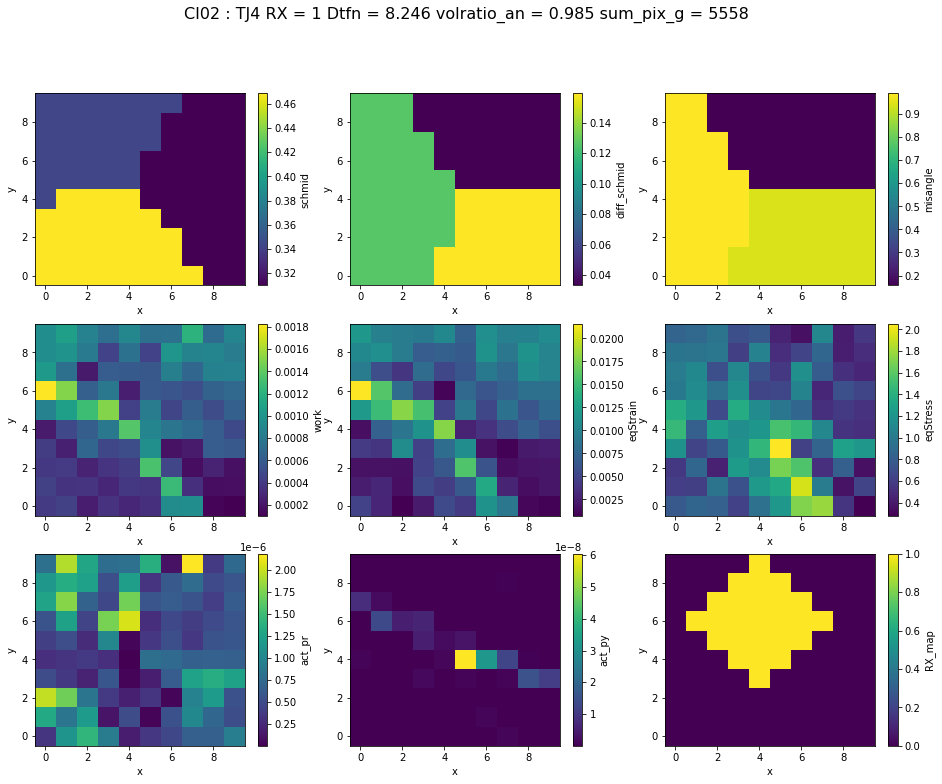

In [5]:
i = 4
fig = plt.figure(figsize=(16,12))
plt.subplot(331)
ds.schmid[i].plot()
plt.subplot(332)
ds.diff_schmid[i].plot()
plt.subplot(333)
ds.misangle[i].plot()
plt.subplot(334)
ds.work[i].plot()
plt.subplot(335)
ds.eqStrain[i].plot()
plt.subplot(336)
ds.eqStress[i].plot()
plt.subplot(337)
ds.act_pr[i].plot()
plt.subplot(338)
ds.act_py[i].plot()
plt.subplot(339)
ds.RX_map[i].plot()
fig.suptitle(name + " : TJ" + str(i) + " RX = "+str(int(ds.RX[i]))+" Dtfn = "+str(round(float(ds.dist_to_1neigh[i]),3))+" volratio_an = "+str(round(float(ds.volratio_an[i]),3))+" sum_pix_g = "+str(int(ds.sum_pix_g[i])),fontsize=16)
plt.show()